APPLE Stock Prediction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics

In [ ]:
df = pd.read_csv('apple.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2019-08-26,51.47,51.80,51.26,51.62,51.12,104174400,0.072340,888
2019-08-27,51.97,52.14,50.88,51.04,50.54,103493200,0.117541,962
2019-08-28,51.03,51.43,50.83,51.38,50.88,63755200,0.061477,895
2019-08-29,52.13,52.33,51.67,52.25,51.74,83962000,0.056460,1083
2019-08-30,52.54,52.61,51.80,52.19,51.67,84573600,0.106096,1005


In [ ]:
df = df[["Adj Close", "ts_polarity", "twitter_volume"]]
df.head()

,Adj Close,ts_polarity,twitter_volume
Date,,,
2016-01-04,24.44,0.070389,1133
2016-01-05,23.83,0.133635,1430
2016-01-06,23.36,0.072042,1949
2016-01-07,22.38,0.074369,2289
2016-01-08,22.50,0.051595,2235


In [ ]:
df["Pct_change"] = df["Adj Close"].pct_change()
df.dropna(inplace = True)
df.head()

,Adj Close,ts_polarity,twitter_volume,Pct_change
Date,,,,
2016-01-05,23.83,0.133635,1430,-0.024959
2016-01-06,23.36,0.072042,1949,-0.019723
2016-01-07,22.38,0.074369,2289,-0.041952
2016-01-08,22.50,0.051595,2235,0.005362
2016-01-11,22.86,0.019443,1222,0.016000


In [ ]:
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    for i in range(len(df) - window):
        
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)
        
    return np.hstack((X_close,X_polarity,X_volume)), np.array(y).reshape(-1, 1)

In [ ]:
window_size = 3

feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [ ]:
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

In [ ]:
X

array([[  23.83,   23.36,   22.38, ..., 1430.  , 1949.  , 2289.  ],
       [  23.36,   22.38,   22.5 , ..., 1949.  , 2289.  , 2235.  ],
       [  22.38,   22.5 ,   22.86, ..., 2289.  , 2235.  , 1222.  ],
       ...,
       [  50.16,   51.12,   50.54, ..., 1103.  ,  888.  ,  962.  ],
       [  51.12,   50.54,   50.88, ...,  888.  ,  962.  ,  895.  ],
       [  50.54,   50.88,   51.74, ...,  962.  ,  895.  , 1083.  ]])

# Scaling Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

## XGBoost Performance


In [ ]:
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=275)

In [ ]:
model.fit(X_train, y_train.ravel())

XGBRegressor(n_estimators=275, objective='reg:squarederror')

In [ ]:
predicted = model.predict(X_test)

In [ ]:
print('RMS Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

RMS Error: 0.04769899029837091
R-squared : 0.9590887271239381


In [ ]:
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2018-07-27,46.39,47.489285
2018-07-30,46.13,46.147499
2018-07-31,46.22,46.530457
2018-08-01,48.95,46.191452
2018-08-02,50.38,48.818722


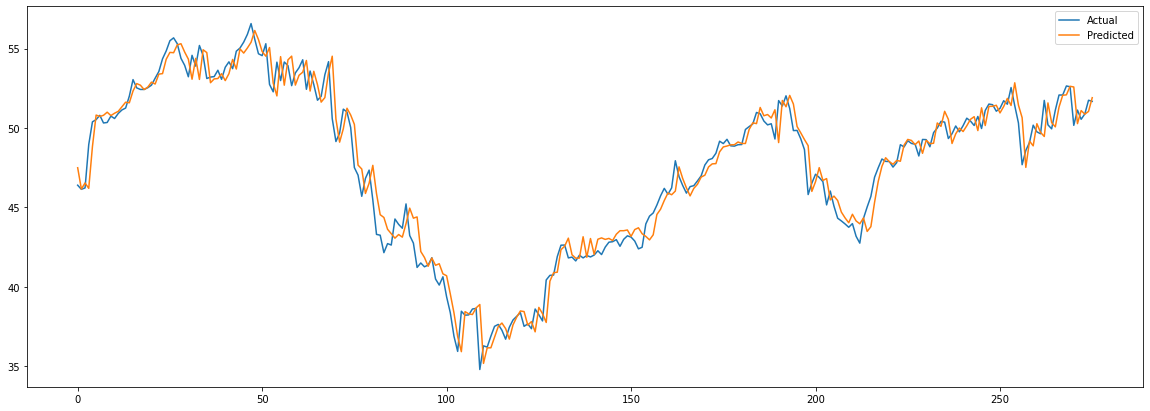

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(real_prices.ravel(),label='Actual')
plt.plot(predicted_prices.ravel(),label='Predicted')
plt.legend()
plt.show()

##Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    model = GradientBoostingRegressor(n_estimators=20,
                                      learning_rate=learning_rate,
                                      max_features=2,
                                      max_depth=3,
                                      random_state=0)
    model.fit(X_train, y_train.ravel())
    print("Learning rate: ", learning_rate)
    
    # Scoring the model
    print("Accuracy score (training): {0:.3f}".format(
        model.score(
            X_train, 
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        model.score(
            X_test, 
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 0.839
Accuracy score (validation): 0.756

Learning rate:  0.1
Accuracy score (training): 0.972
Accuracy score (validation): 0.917

Learning rate:  0.25
Accuracy score (training): 0.995
Accuracy score (validation): 0.945

Learning rate:  0.5
Accuracy score (training): 0.995
Accuracy score (validation): 0.927

Learning rate:  0.75
Accuracy score (training): 0.996
Accuracy score (validation): 0.910

Learning rate:  1
Accuracy score (training): 0.997
Accuracy score (validation): 0.880



In [ ]:
model = GradientBoostingRegressor(n_estimators=20,
                                      learning_rate=0.25,
                                      max_features=2,
                                      max_depth=3,
                                      random_state=0)

model.fit(X_train,y_train.ravel())

GradientBoostingRegressor(learning_rate=0.25, max_features=2, n_estimators=20,
                          random_state=0)

In [ ]:
predicted = model.predict(X_test)

In [ ]:
print('RMS Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

RMS Error: 0.055389603932779884
R-squared : 0.9448327749045738


In [ ]:
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2018-07-27,46.39,47.269256
2018-07-30,46.13,47.399553
2018-07-31,46.22,47.353150
2018-08-01,48.95,46.763746
2018-08-02,50.38,46.486706


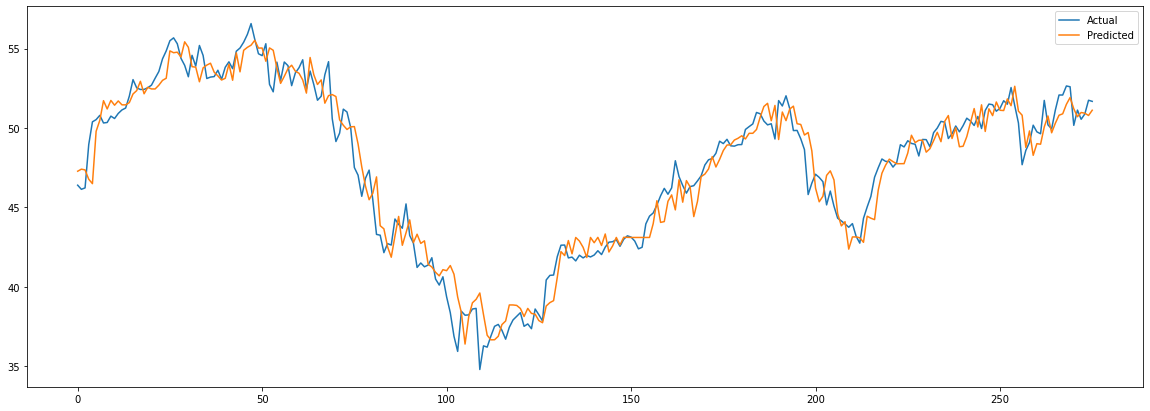

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(real_prices.ravel(),label='Actual')
plt.plot(predicted_prices.ravel(),label='Predicted')
plt.legend()
plt.show()

##LightGBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
model = LGBMRegressor(n_estimators=42, max_depth=2,min_samples_leaf=10)

In [ ]:
model.fit(X_train, y_train.ravel())

LGBMRegressor(max_depth=2, min_samples_leaf=10, n_estimators=42)

In [ ]:
predicted = model.predict(X_test)

In [ ]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.04549112284277919
R-squared : 0.9627884351956575


In [ ]:
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2018-07-27,46.39,47.459950
2018-07-30,46.13,46.299810
2018-07-31,46.22,46.251242
2018-08-01,48.95,46.164917
2018-08-02,50.38,48.966563


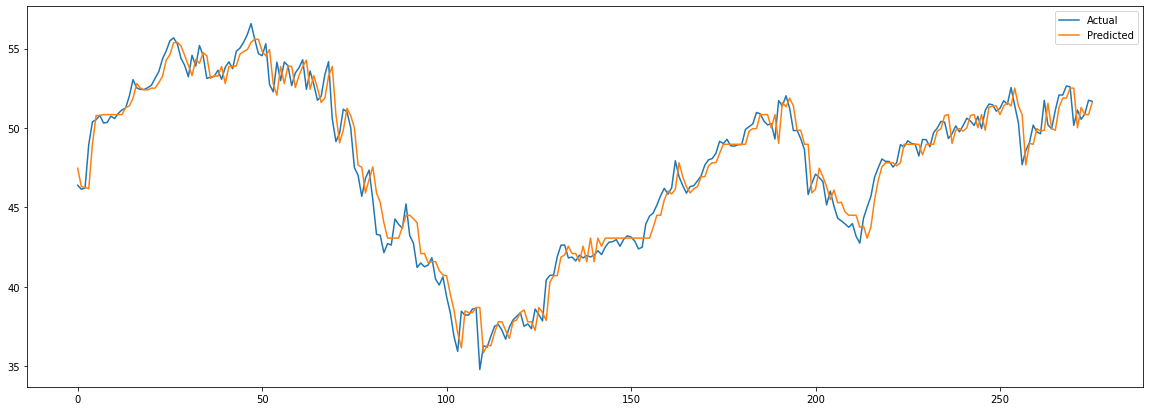

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(real_prices.ravel(),label='Actual')
plt.plot(predicted_prices.ravel(),label='Predicted')
plt.legend()
plt.show()